In [2]:
!pip install -Uqq fastai

In [3]:
from fastai.vision.all import *

In [4]:
from fastai.vision.widgets import *


In [5]:
from duckduckgo_search import DDGS

In [6]:
def search_images(keywords, max_images=350):
    with DDGS() as ddgs:
        return [img['image'] for img in ddgs.images(keywords=keywords, size=None, max_results=max_images)]

In [7]:
urls = search_images('grizzly bear', max_images=350)

In [8]:
len(urls)

330

In [8]:
print(urls)

['http://2.bp.blogspot.com/-NjMTuklENdE/UHzVv_8dIxI/AAAAAAAAA-U/tNBsQDn8kFI/s1600/Grizzly+Bear+Pic.jpg', 'https://d3d0lqu00lnqvz.cloudfront.net/media/media/897b2e5d-6d4c-40fa-bbe8-6829455747e2.jpg', 'http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly+Bear+Wildlife.jpg', 'https://cdn.britannica.com/19/186719-050-887A6F2C/Grizzly-bear-Rocky-Mountains-Wyoming.jpg', 'https://cdn.britannica.com/18/161718-050-2DB34DD6/Grizzly-bear.jpg', 'https://www.goodfreephotos.com/albums/animals/mammals/grizzly-bear-in-the-wild.jpg', 'https://www.animalfactsencyclopedia.com/images/grizzlybearstanding.jpg', 'https://thelatebloomerhiker.files.wordpress.com/2014/11/grizzly-bear-22224-1920x1200.jpg', 'https://www.publicdomainpictures.net/pictures/240000/velka/grizzly-bear-portrait-1511961987XRY.jpg', 'https://canadiangeographic.ca/wp-content/uploads/2022/08/36211246-Grizzly_Bear_Siblings-scaled.jpg', 'https://www.earthrangers.com/public/content/wildwire/GrizzlyBearJeanBea

In [9]:
path = Path('bears')
bear_types = 'grizzly','black','teddy'

In [10]:
for o in bear_types:
    dest = path/o
    if not dest.exists():
        dest.mkdir()
    urls = search_images(f'{o} bear')
    download_images(dest, urls=urls)
    resize_images(dest, max_size=400, dest=dest)

/opt/conda/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [15]:
fns = get_image_files(path)
fns

(#1526) [Path('bears/grizzly/4fbbf783-a671-4bd3-aaae-41686bc32146.jpg'),Path('bears/grizzly/4a78183d-ac4c-4268-8ce0-0b3831be3ff0.jpg'),Path('bears/grizzly/08a9ae68-46b6-4181-9cdd-aaffbfb08bab.jpg'),Path('bears/grizzly/412a859f-ffd6-4349-b798-21bb9dfa7bee.jpg'),Path('bears/grizzly/db583471-60d8-42eb-8881-51f1c85b0805.jpeg'),Path('bears/grizzly/9e5b1cd6-6405-4638-9533-a46fd8f9ec9d.jpg'),Path('bears/grizzly/6aa6da64-67be-404e-aed4-c154771460be.jpg'),Path('bears/grizzly/a4555980-f38e-41ff-82f1-b38c2b8b9f9d.jpg'),Path('bears/grizzly/c810a12a-528a-43f6-9115-1347d797326c.jpg'),Path('bears/grizzly/fb1b620a-19f6-4ae1-96a7-ebf751cd220b.jpg')...]

In [16]:
failed = verify_images(fns)
failed

(#0) []

In [17]:
failed.map(Path.unlink);

In [18]:
??verify_images

Signature: verify_images(fns)
Source:   
def verify_images(fns):
    "Find images in `fns` that can't be opened"
    return L(fns[i] for i,o in enumerate(parallel(verify_image, fns)) if not o)
File:      /opt/conda/lib/python3.11/site-packages/fastai/vision/utils.py
Type:      function

In [19]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [20]:
dls = bears.dataloaders(path)

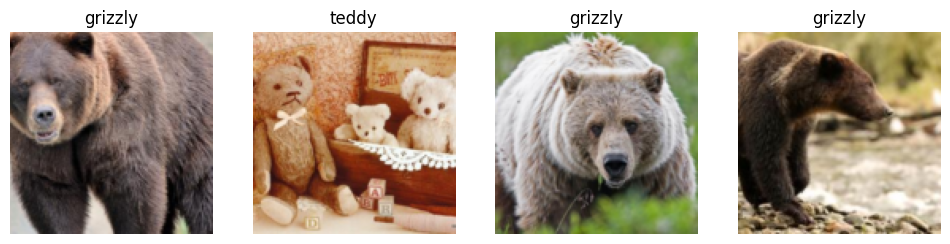

In [21]:
dls.valid.show_batch(max_n=4, nrows=1)

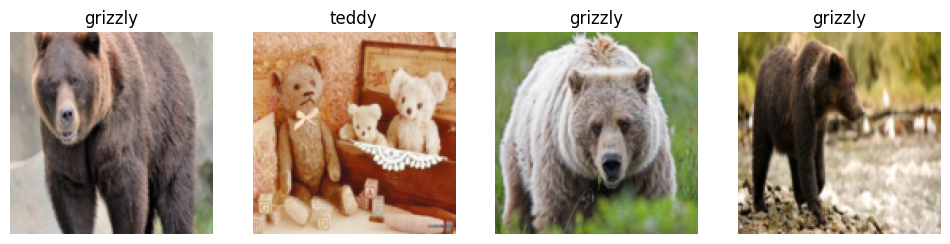

In [22]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

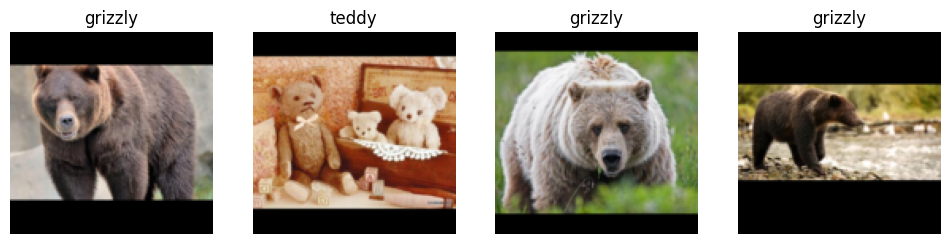

In [23]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

In [24]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)

In [25]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.867563,0.589112,0.098361,00:21


epoch,train_loss,valid_loss,error_rate,time
0,0.249999,0.286685,0.059016,00:28
1,0.215198,0.268590,0.059016,00:28
2,0.175986,0.217829,0.049180,00:28
3,0.157875,0.208829,0.055738,00:28


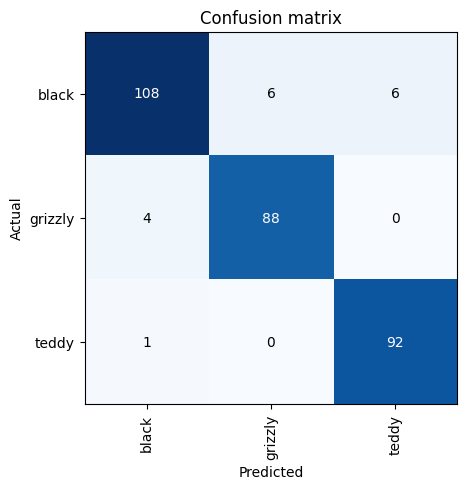

In [26]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

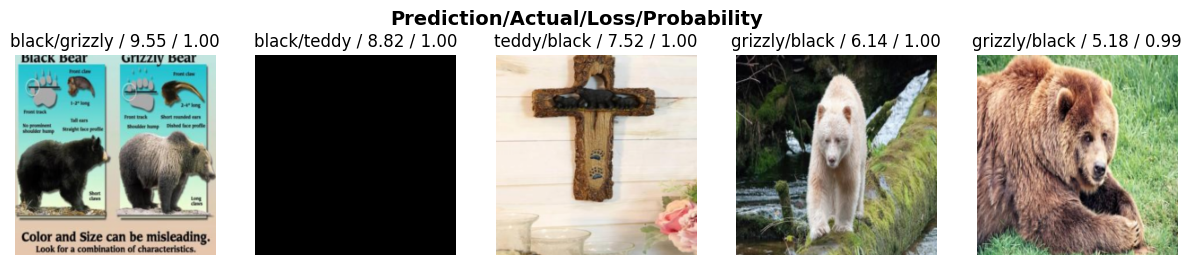

In [27]:
interp.plot_top_losses(5, nrows=1)

In [29]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

In [35]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [36]:
learn.export()

In [37]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [38]:
learn_inf = load_learner(path/'export.pkl')

In [39]:
learn_inf.predict('grizzly.jpg')

('grizzly', tensor(1), tensor([9.7761e-03, 9.9022e-01, 2.1934e-06]))

In [40]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']